## EECE5644 Assignment 3 - Question 2

#### Import Libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
import seaborn as sns
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings('ignore')

np.random.seed(67)

#### Define GMM Models for Data Generation

In [ ]:
class TrueGMM:
    
    def __init__(self):
        self.n_components = 4
        
        # Mixing weights (probabilities)
        self.weights = np.array([0.25, 0.35, 0.20, 0.20])
        
        # Mean vectors for each component
        # Components 0 and 1 are close (significant overlap)
        self.means = [
            np.array([0.0, 0.0]),      # Component 1
            np.array([2.0, 2.0]),      # Component 2 (overlaps with 1)
            np.array([8.0, 0.0]),      # Component 3 (separated)
            np.array([0.0, 8.0])       # Component 4 (separated)
        ]
        
        # Covariance matrices
        # Components 0 and 1 have similar scales for overlap
        self.covariances = [
            np.array([[1.5, 0.5],
                     [0.5, 1.5]]),     # Component 1
            
            np.array([[1.5, -0.3],
                     [-0.3, 1.5]]),    # Component 2 (overlaps with 1)
            
            np.array([[1.0, 0.2],
                     [0.2, 1.0]]),     # Component 3
            
            np.array([[1.2, -0.2],
                     [-0.2, 1.2]])     # Component 4
        ]
        
        # Verify overlap between components 0 and 1
        distance = np.linalg.norm(self.means[0] - self.means[1])
        avg_eigenvalues = (np.mean(np.linalg.eigvals(self.covariances[0])) + 
                          np.mean(np.linalg.eigvals(self.covariances[1]))) / 2
        print(f"True GMM Configuration:")
        print(f"  - Number of components: {self.n_components}")
        print(f"  - Distance between component 1 and 2: {distance:.2f}")
        print(f"  - Average eigenvalue: {avg_eigenvalues:.2f}")
        print(f"  - Overlap ratio: {distance/avg_eigenvalues:.2f} (< 2.0 indicates significant overlap)")
        print()
        
    def generate_data(self, n_samples):
        """Generate samples from the true GMM"""
        X = []
        component_labels = []
        
        # Determine number of samples from each component
        n_per_component = np.random.multinomial(n_samples, self.weights)
        
        for k in range(self.n_components):
            if n_per_component[k] > 0:
                # Generate samples from this component
                samples = multivariate_normal.rvs(
                    mean=self.means[k],
                    cov=self.covariances[k],
                    size=n_per_component[k]
                )
                
                if n_per_component[k] == 1:
                    samples = samples.reshape(1, -1)
                
                X.append(samples)
                component_labels.extend([k] * n_per_component[k])
        
        X = np.vstack(X)
        component_labels = np.array(component_labels)
        
        # Shuffle the data
        indices = np.random.permutation(len(component_labels))
        return X[indices], component_labels[indices]
    
    def compute_log_likelihood(self, X):
        """Compute log-likelihood of data under true GMM"""
        n_samples = X.shape[0]
        log_likelihood = 0.0
        
        for i in range(n_samples):
            # Compute mixture density
            density = 0.0
            for k in range(self.n_components):
                density += self.weights[k] * multivariate_normal.pdf(
                    X[i], 
                    mean=self.means[k], 
                    cov=self.covariances[k]
                )
            log_likelihood += np.log(density + 1e-300)
        
        return log_likelihood

#### Fit GMM using EM algorithm

In [4]:
def fit_gmm_em(X, n_components, max_iter=200, n_init=5):
    best_gmm = None
    best_log_likelihood = -np.inf
    
    for init in range(n_init):
        try:
            gmm = GaussianMixture(
                n_components=n_components,
                covariance_type='full',
                max_iter=max_iter,
                n_init=1,
                random_state=init,
                reg_covar=1e-6
            )
            
            gmm.fit(X)
            log_likelihood = gmm.score(X) * len(X)  # Total log-likelihood
            
            if log_likelihood > best_log_likelihood:
                best_log_likelihood = log_likelihood
                best_gmm = gmm
                
        except Exception as e:
            continue
    
    return best_gmm, best_log_likelihood

#### Cross-Validation for Model Order Selection

In [5]:
def cross_validate_gmm(X, n_components, n_folds=10):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train_fold = X[train_idx]
        X_val_fold = X[val_idx]
        
        # Fit GMM on training fold
        gmm, _ = fit_gmm_em(X_train_fold, n_components, n_init=3)
        
        if gmm is not None:
            # Evaluate on validation fold
            val_log_likelihood = gmm.score(X_val_fold) * len(X_val_fold)
            fold_scores.append(val_log_likelihood)
        else:
            fold_scores.append(-np.inf)
    
    avg_val_log_likelihood = np.mean(fold_scores)
    return avg_val_log_likelihood, fold_scores

#### Experiment Set-up (Single and Repeated Experiments)

In [6]:
def single_experiment(true_gmm, n_samples, candidate_orders, n_folds=10):
    # Generate data
    X, _ = true_gmm.generate_data(n_samples)
    
    # Evaluate each candidate model order
    cv_scores = {}
    
    for K in candidate_orders:
        avg_score, fold_scores = cross_validate_gmm(X, K, n_folds)
        cv_scores[K] = avg_score
    
    # Select best model order
    selected_order = max(cv_scores, key=cv_scores.get)
    
    return selected_order, cv_scores


def run_multiple_experiments(n_experiments=100):
    
    # Initialize true GMM
    true_gmm = TrueGMM()
    
    # Dataset sizes
    dataset_sizes = [10, 100, 1000]
    
    # Candidate model orders
    candidate_orders = list(range(1, 11))  # 1, 2, ..., 10
    
    # Store results
    results = {size: {K: 0 for K in candidate_orders} for size in dataset_sizes}
    
    # Run experiments
    for size in dataset_sizes:
        print(f"Running {n_experiments} experiments with {size} samples...")
        print("-"*80)
        
        for exp in range(n_experiments):
            if (exp + 1) % 10 == 0:
                print(f"  Experiment {exp + 1}/{n_experiments}...", end='\r')
            
            selected_order, cv_scores = single_experiment(
                true_gmm, size, candidate_orders, n_folds=10
            )
            
            results[size][selected_order] += 1
        
        print(f"  Completed {n_experiments} experiments for {size} samples")
        print()
    
    return results, true_gmm

#### Results and Visualization

In [7]:
def visualize_results(results, true_gmm):
    dataset_sizes = list(results.keys())
    candidate_orders = list(range(1, 11))
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for idx, size in enumerate(dataset_sizes):
        ax = axes[idx]
        
        # Get selection rates
        counts = [results[size][K] for K in candidate_orders]
        total = sum(counts)
        rates = [count / total * 100 for count in counts]
        
        # Create bar plot
        bars = ax.bar(candidate_orders, rates, color=colors, alpha=0.7, edgecolor='black')
        
        # Highlight the true order
        true_order_idx = true_gmm.n_components - 1
        bars[true_order_idx].set_color('red')
        bars[true_order_idx].set_alpha(1.0)
        bars[true_order_idx].set_edgecolor('darkred')
        bars[true_order_idx].set_linewidth(2)
        
        ax.set_xlabel('Number of Components (K)', fontsize=12)
        ax.set_ylabel('Selection Rate (%)', fontsize=12)
        ax.set_title(f'N = {size} samples', fontsize=14, fontweight='bold')
        ax.set_xticks(candidate_orders)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, max(rates) * 1.2 if max(rates) > 0 else 10])
        
        # Add legend for true order
        if idx == 2:
            ax.legend([bars[true_order_idx]], ['True Order (K=4)'], 
                     loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()


def create_detailed_table(results, true_gmm):
    dataset_sizes = list(results.keys())
    candidate_orders = list(range(1, 11))
    
    print("\nDETAILED RESULTS TABLE")
    print("="*80)
    print()
    
    for size in dataset_sizes:
        print(f"Dataset Size: {size} samples")
        print(f"{'Model Order (K)':<20} {'Selection Count':<20} {'Selection Rate (%)':<20}")
        print("-"*80)
        
        counts = [results[size][K] for K in candidate_orders]
        total = sum(counts)
        
        for K in candidate_orders:
            count = results[size][K]
            rate = count / total * 100
            
            marker = " ← TRUE ORDER" if K == true_gmm.n_components else ""
            print(f"{K:<20} {count:<20} {rate:<20.2f}{marker}")
        
        print()
    
    # Summary statistics
    print("="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print()
    
    for size in dataset_sizes:
        counts = [results[size][K] for K in candidate_orders]
        total = sum(counts)
        
        # Most frequently selected order
        most_common_K = max(candidate_orders, key=lambda k: results[size][k])
        most_common_rate = results[size][most_common_K] / total * 100
        
        # Correct selection rate (K=4)
        correct_rate = results[size][true_gmm.n_components] / total * 100
        
        print(f"N = {size} samples:")
        print(f"  Most frequently selected K: {most_common_K} ({most_common_rate:.1f}%)")
        print(f"  True order (K=4) selected: {correct_rate:.1f}%")
        print()


def visualize_data_samples(true_gmm):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    dataset_sizes = [10, 100, 1000]
    
    for idx, size in enumerate(dataset_sizes):
        ax = axes[idx]
        
        # Generate data
        X, labels = true_gmm.generate_data(size)
        
        # Plot data points colored by true component
        scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', 
                           alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        # Plot true component means
        for k in range(true_gmm.n_components):
            ax.plot(true_gmm.means[k][0], true_gmm.means[k][1], 
                   'r*', markersize=20, markeredgecolor='black', 
                   markeredgewidth=1.5)
        
        ax.set_xlabel('X₁', fontsize=12)
        ax.set_ylabel('X₂', fontsize=12)
        ax.set_title(f'Sample Data (N = {size})', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()

#### Run Experiments

True GMM Configuration:
  - Number of components: 4
  - Distance between component 1 and 2: 2.83
  - Average eigenvalue: 1.50
  - Overlap ratio: 1.89 (< 2.0 indicates significant overlap)

Running 100 experiments with 10 samples...
--------------------------------------------------------------------------------
  Completed 100 experiments for 10 samples

Running 100 experiments with 100 samples...
--------------------------------------------------------------------------------
  Completed 100 experiments for 100 samples

Running 100 experiments with 1000 samples...
--------------------------------------------------------------------------------
  Completed 100 experiments for 1000 samples


DETAILED RESULTS TABLE

Dataset Size: 10 samples
Model Order (K)      Selection Count      Selection Rate (%)  
--------------------------------------------------------------------------------
1                    90                   90.00               
2                    9                    9.

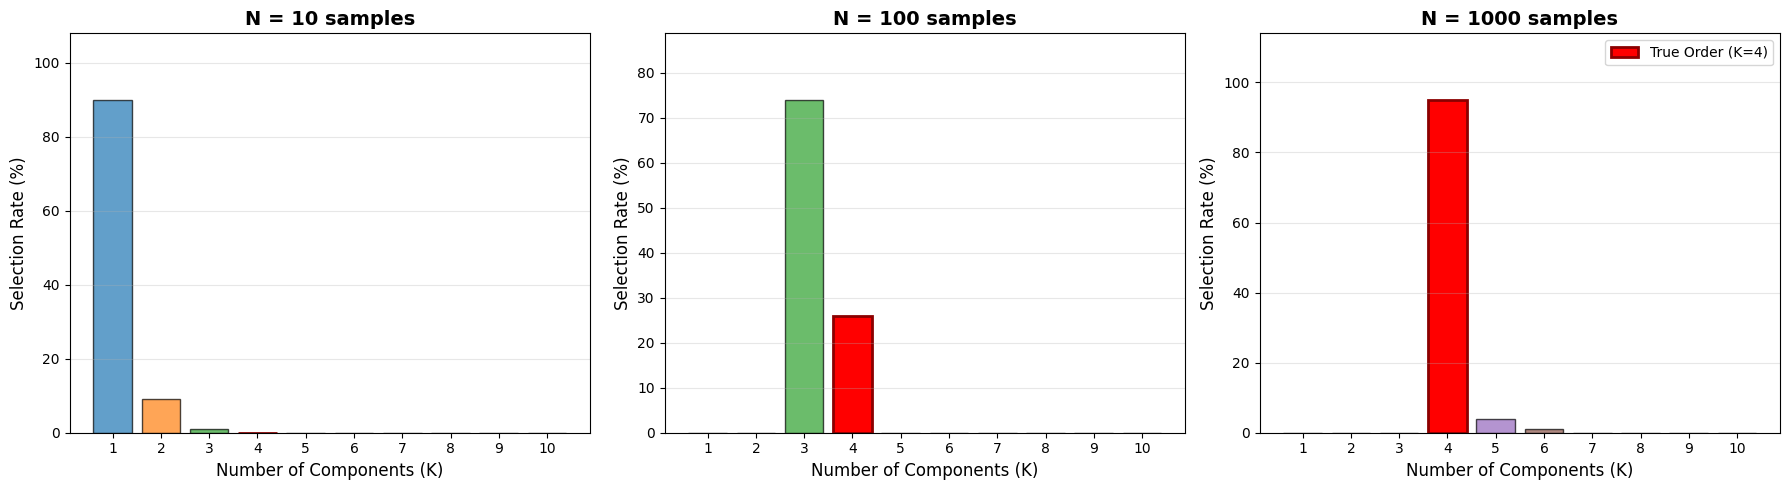

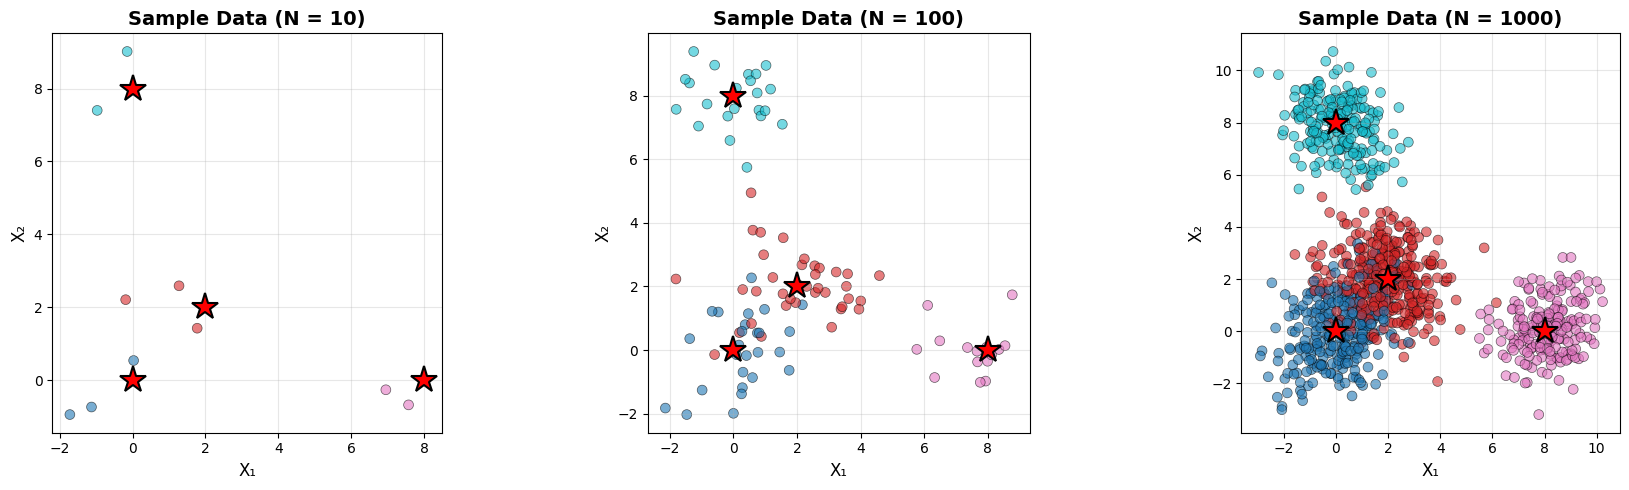

EXPERIMENT COMPLETED SUCCESSFULLY!



In [10]:
# Run multiple experiments
results, true_gmm = run_multiple_experiments(n_experiments=100)

# Create detailed results table
create_detailed_table(results, true_gmm)

# Visualize results
print("\nGenerating visualizations...")
visualize_results(results, true_gmm)

# Visualize sample data
visualize_data_samples(true_gmm)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print()